In [33]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# Constants
NSHARDS = 10
MODELS = ['MLP', 'GCN', 'HGCN']

In [44]:
def df_gen(RESULTS_DIR, NSHARDS):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [62]:
def plot_gen(df, METRIC):
	plt.scatter(df["MLP__" + METRIC], df["GCN__" + METRIC], s=5)
	plt.plot([0, 1], [0, 1], color='red', linestyle='--')
	plt.title(f'Performance comparison between GCN and MLP')
	plt.xlabel(f'{"GCN__" + METRIC}')
	plt.ylabel(f'{"MLP__" + METRIC}')
	plt.legend(fontsize='small')
	plt.tight_layout()
	plt.show()
	
	cluster_sizes = df['num_clusters'].unique()
	fig, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		MLP_better = df_2_clusters["MLP__" + METRIC] > df_2_clusters["GCN__" + METRIC]+.05
		GCN_better = df_2_clusters["GCN__" + METRIC] > df_2_clusters["MLP__" + METRIC]+.05
		total_samples = len(MLP_better)

		ax = axes[axes_index]
		ax.scatter(df_2_clusters["GCN__" + METRIC][MLP_better],
				df_2_clusters["MLP__" + METRIC][MLP_better], color = 'orange', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][GCN_better],
				df_2_clusters["MLP__" + METRIC][GCN_better], color = 'green', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][~(MLP_better | GCN_better)],
				df_2_clusters["MLP__" + METRIC][~(MLP_better | GCN_better)], s = 5)
		ax.plot([0, 1], [0, 1], color='red', linestyle='--')
		ax.scatter([], [], label=f"MLP better: {sum(MLP_better)}", color = 'orange')
		ax.scatter([], [], label=f"GCN better: {sum(GCN_better)}", color = 'green')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"GCN__" + METRIC}')
		ax.set_ylabel(f'{"MLP__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP as number of classes increases")
	plt.tight_layout()
	plt.show()

	cluster_sizes = df['num_clusters'].unique()
	_, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		small_mask = df_2_clusters['nvertex'] < 2000
		mid_mask = (df_2_clusters['nvertex'] >= 2000) & (df_2_clusters['nvertex'] < 3000)
		large_mask = df_2_clusters['nvertex'] >= 3000
		ax = axes[axes_index]
		ax.scatter(df_2_clusters["MLP__" + METRIC][small_mask], df_2_clusters["GCN__" + METRIC][small_mask], s=10, color = 'green', label = '1000-2000')
		ax.scatter(df_2_clusters["MLP__" + METRIC][mid_mask], df_2_clusters["GCN__" + METRIC][mid_mask], s=10, color = 'orange', label = '2000-3000')    
		ax.scatter(df_2_clusters["MLP__" + METRIC][large_mask], df_2_clusters["GCN__" + METRIC][large_mask], s=10, color = 'red', label = '3000-4000')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"MLP__" + METRIC}')
		ax.set_ylabel(f'{"GCN__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP based on graph size, stratified across number of classes")
	plt.tight_layout()
	plt.show()


	models = ['MLP', 'GCN', 'HGCN']

	plt.figure(figsize=(10, 6))

	for model in models:
		grouped = df.groupby('num_clusters')[f'{model}__test_accuracy']
		means = grouped.mean()
		stds = grouped.std()

		plt.errorbar(
			means.index, means.values, yerr=stds.values, fmt='o-', capsize=5, label=model
		)

	# Add random guessing baseline
	cluster_sizes = sorted(df['num_clusters'].unique())
	random_guess = [1 / c for c in cluster_sizes]
	plt.plot(cluster_sizes, random_guess, 'k--', label='Random Guessing')

	plt.xlabel('Number of Clusters')
	plt.ylabel('Accuracy')
	plt.title('Model Accuracy vs. Number of Clusters (mean ± std)')
	plt.grid(True)
	plt.legend()
	plt.tight_layout()
	plt.show()

In [ ]:
RESULTS_DIR_random_gs = '../../graph_gen/snellius_gen/random_gs/random_gs'
results_df_random_gs = df_gen(RESULTS_DIR_random_gs, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [52]:
smaller_graphs_df = df_gen("../../graph_gen/snellius_gen/smaller_graphs/smaller_graphs/", NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


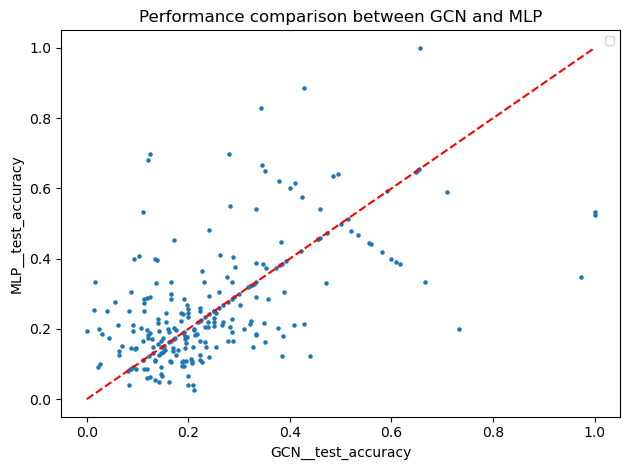

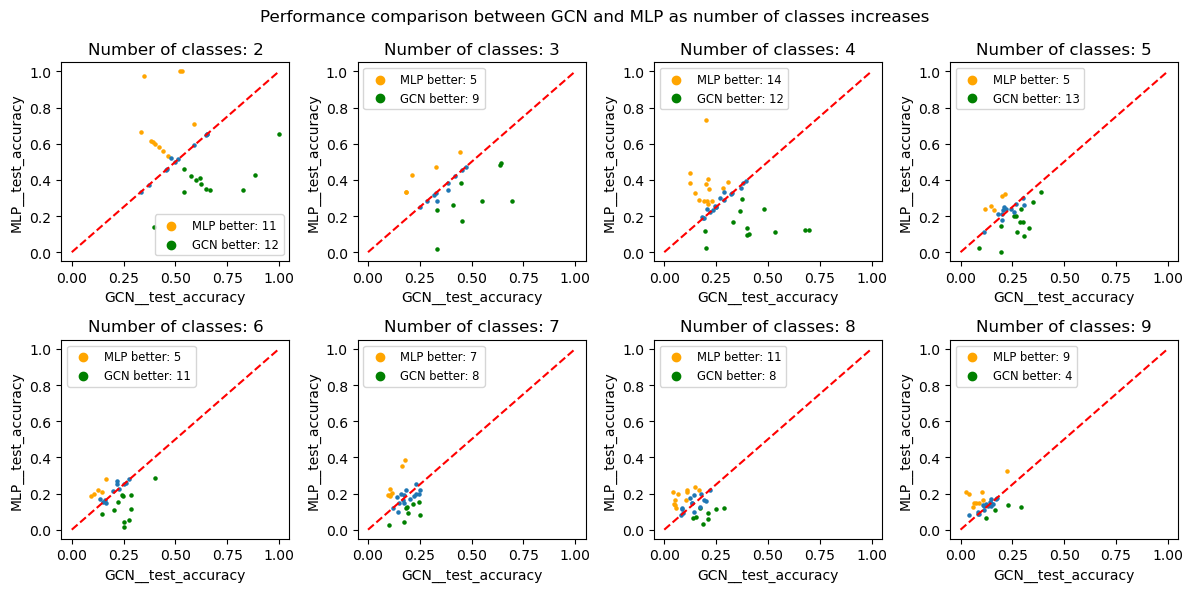

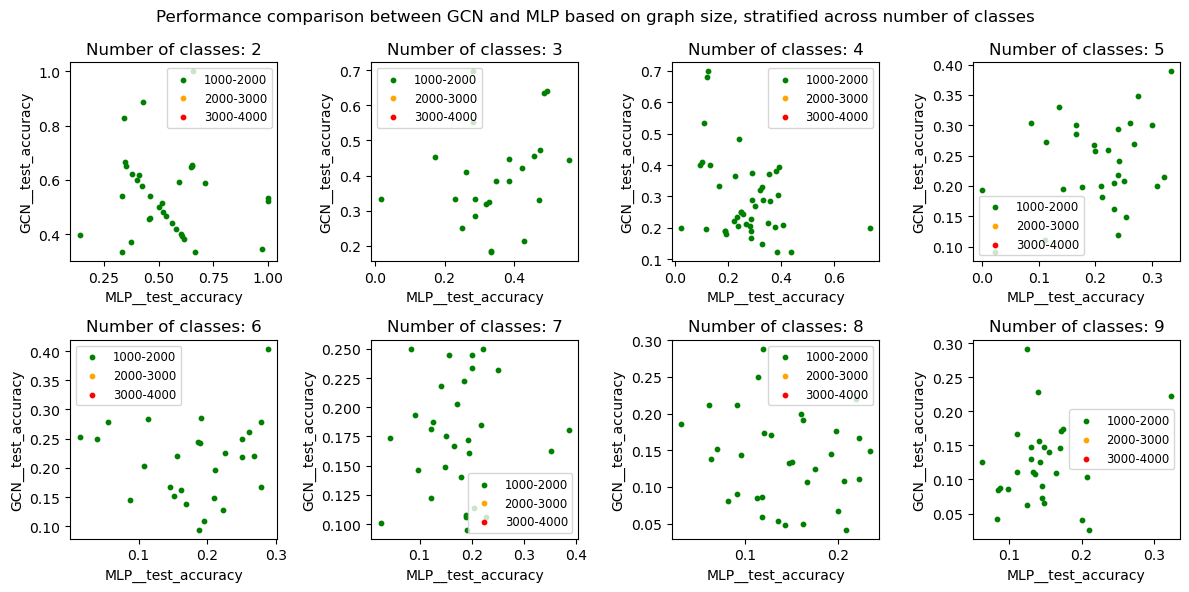

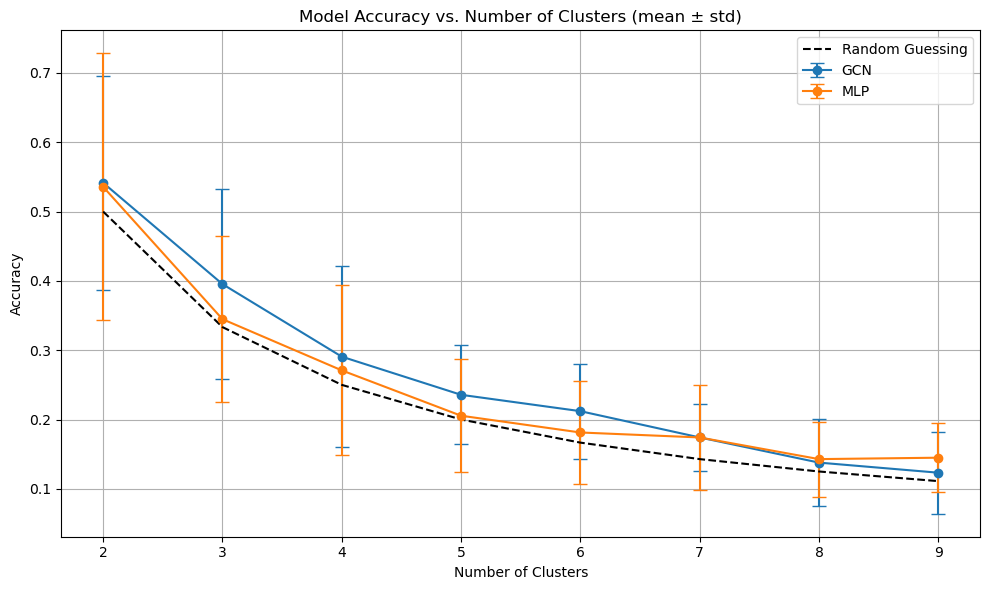

In [63]:
plot_gen(smaller_graphs_df, "test_accuracy")

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


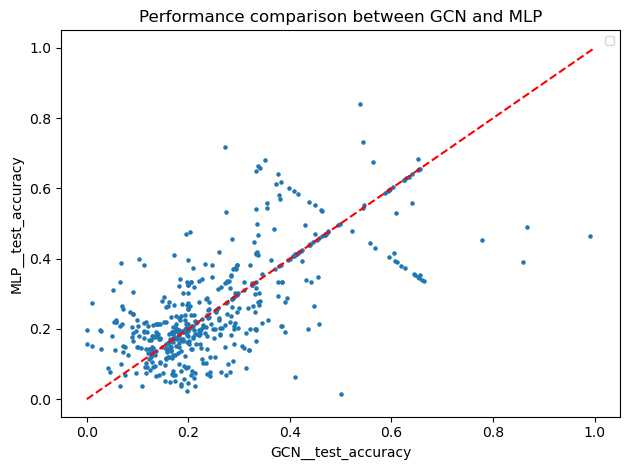

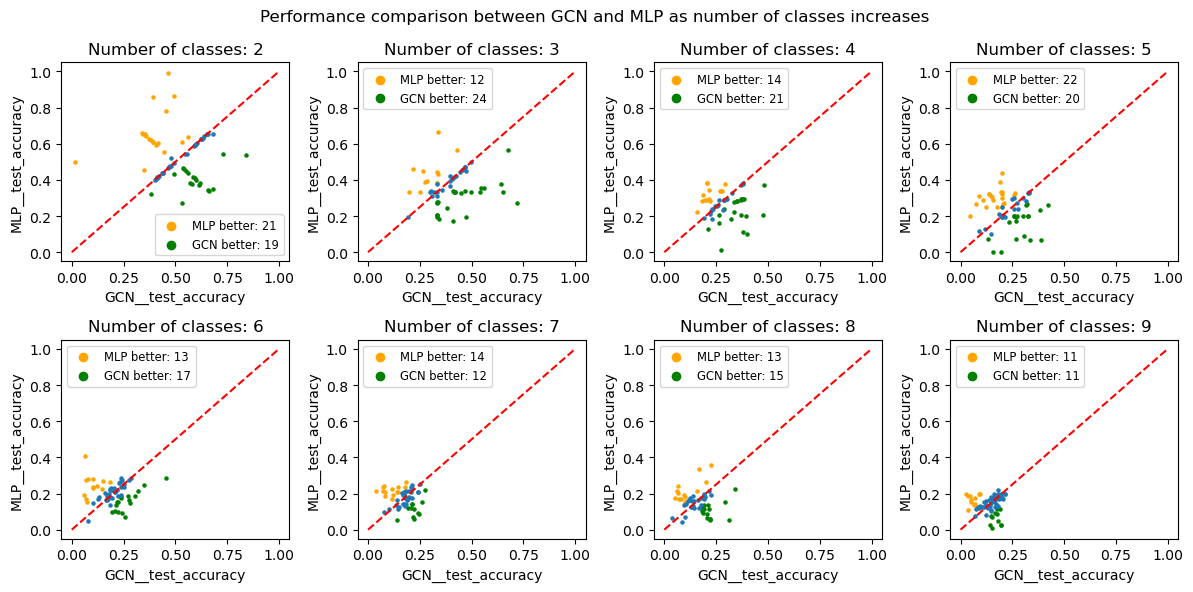

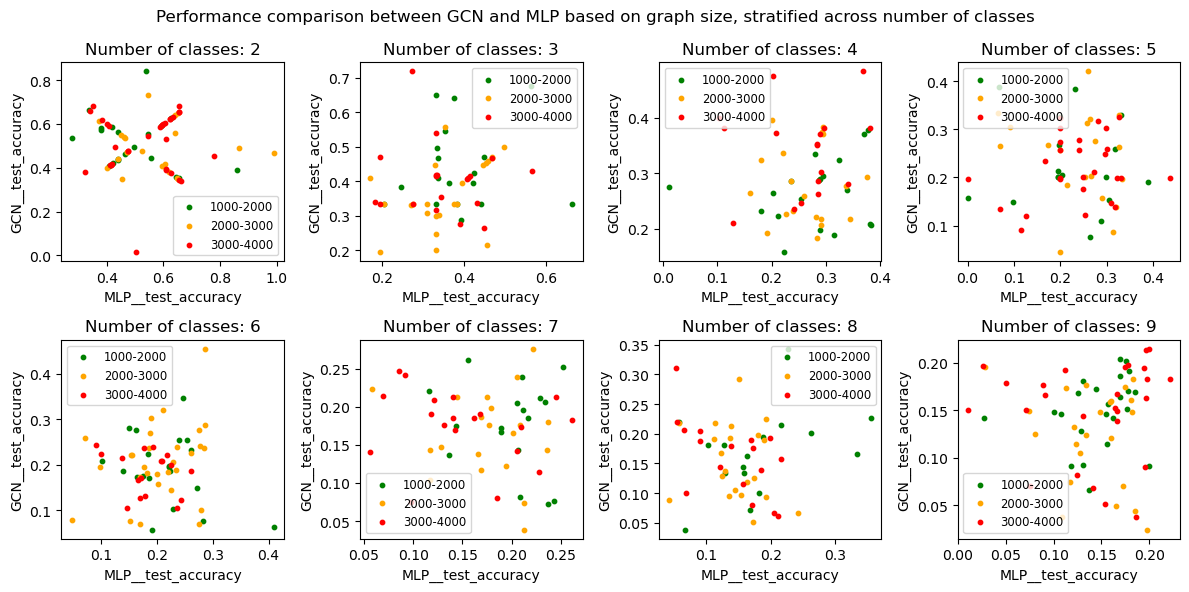

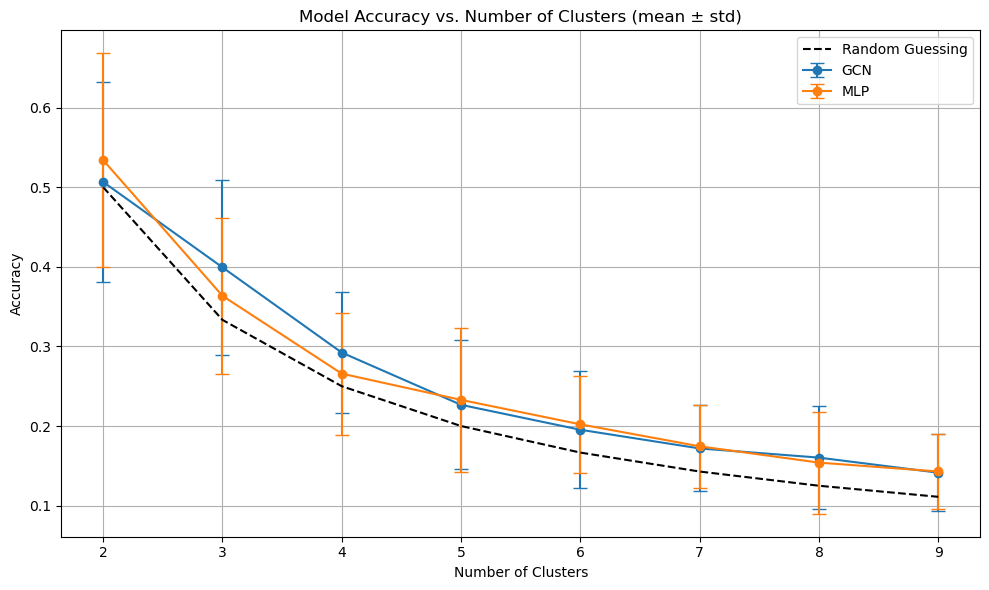

In [65]:
main_snellius_gen_link = "../../graph_gen/snellius_gen/nodeclassification/sbm/"
main_snellius_df = df_gen(main_snellius_gen_link, NSHARDS)
plot_gen(main_snellius_df, "test_accuracy")

## Varied feature dim investigations

In [114]:
RESULTS_DIR = '../../graph_gen/snellius_gen/vary_dim/'
two_df = df_gen(RESULTS_DIR= RESULTS_DIR + '2', NSHARDS = NSHARDS)
eight_df = df_gen(RESULTS_DIR= RESULTS_DIR + '8', NSHARDS = NSHARDS)
sixteen_df = df_gen(RESULTS_DIR= RESULTS_DIR + '16', NSHARDS = NSHARDS)
cts_hyp_df = df_gen(RESULTS_DIR=RESULTS_DIR + 'cts_hyp', NSHARDS=NSHARDS)


results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

def boxplot_metric_by_feature_dim(combined_df, models, metric, figsize=(8, 6)):
    """
    Create a boxplot of <model>__<metric> grouped by feature_dim, 
    for each model in `models`.
    
    Args:
        combined_df: DataFrame containing all feature_dim batches plus results.
        models: list of model prefixes, e.g. ['GCN', 'MLP', 'HGCN']
        metric: the performance metric suffix, e.g. 'test_accuracy'
        figsize: figure size tuple
    """
    colnames = [f"{m}__{metric}" for m in models]
    combined_df.boxplot(
        column=colnames,
        by='feature_dim',
        grid=True,
        patch_artist=False,
        boxprops=dict(color='orange'),
        medianprops=dict(color='red')
    )
    plt.suptitle('') 
    plt.title('')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Feature Dimension')
    plt.show()


def scatter_model_vs_model_given_dim(combined_df, model_x, model_y, metric, dim, cmap='viridis', figsize=(6, 6)):
    """
    Scatter plot of model_x vs model_y on <metric>, colored by feature_dim.
    
    Args:
        combined_df: the combined DataFrame.
        model_x: prefix string for X model, e.g. 'GCN'
        model_y: prefix string for Y model, e.g. 'HGCN'
        metric: performance metric suffix, e.g. 'test_accuracy'
        cmap: colormap for feature_dim
        figsize: size of figure
    """
    xcol = f"{model_x}__{metric}"
    ycol = f"{model_y}__{metric}"
    scatter = plt.scatter(
        combined_df[xcol][combined_df['feature_dim'] == dim],
        combined_df[ycol][combined_df['feature_dim'] == dim],
        cmap=cmap,
        alpha=0.7,
        edgecolors='w',
        s=60
    )

    plt.plot([combined_df[xcol][combined_df['feature_dim'] == dim].min(), combined_df[xcol][combined_df['feature_dim'] == dim].max()], 
             [combined_df[xcol][combined_df['feature_dim'] == dim].min(), combined_df[xcol][combined_df['feature_dim'] == dim].max()], 
             'r--', linewidth=1)
    # cbar = plt.colorbar(scatter)
    # cbar.set_label('feature_dim')
    plt.xlabel(f"{model_x} {metric.replace('_', ' ').title()}")
    plt.ylabel(f"{model_y} {metric.replace('_', ' ').title()}")
    plt.title(f"{model_x} vs {model_y} ({metric.replace('_', ' ').title()}) and feature dim {dim}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def boxplot_metric_vs_train_size(combined_df, model, metric, figsize=(8, 6)):
    """
    Boxplot of <model>__<metric> vs num_train_per_class, with hue=feature_dim.
    
    Args:
        combined_df: the combined DataFrame
        model: model prefix, e.g. 'HGCN'
        metric: performance metric suffix, e.g. 'test_accuracy'
        figsize: size of figure
    """
    colname = f"{model}__{metric}"
    plt.figure(figsize=figsize)
    sns.boxplot(
        x='num_train_per_class',
        y=colname,
        hue='feature_dim',
        data=combined_df,
        palette='magma'
    )
    plt.title(f"{model} {metric.replace('_', ' ').title()} vs Num Train per Class")
    plt.xlabel('Num Train per Class')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(title='feature_dim')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_performance_vs_clusters(combined_df, model, metric):
    """
    Plots the average performance (given by `model__metric`) 
    versus number of ground‐truth clusters, for each feature_dim.
    Also includes a random‐guessing baseline (accuracy = 1/num_clusters).

    Args:
      combined_df: DataFrame containing at least these columns:
                   - 'feature_dim'
                   - 'num_clusters'
                   - f"{model}__{metric}"  (e.g. "HGCN__test_accuracy")
      model:       String prefix of the model, e.g. 'GCN', 'MLP', or 'HGCN'.
      metric:      String suffix of the performance metric, e.g. 'test_accuracy'.
    """
    colname = f"{model}__{metric}"
    # Drop any rows where the required columns are missing
    df = combined_df[['feature_dim', 'num_clusters', colname]].dropna()

    # Compute mean performance per (feature_dim, num_clusters)
    grouped = (
        df
        .groupby(['feature_dim', 'num_clusters'])[colname]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8, 6))
    for dim in sorted(grouped['feature_dim'].unique()):
        sub = grouped[grouped['feature_dim'] == dim]
        plt.plot(
            sub['num_clusters'],
            sub[colname],
            marker='o',
            label=f"{model}, feat_dim={dim}"
        )

    # Random‐guessing baseline: accuracy = 1/num_clusters
    all_clusters = sorted(df['num_clusters'].unique())
    random_baseline = [1.0 / k for k in all_clusters]
    plt.plot(
        all_clusters,
        random_baseline,
        'k--',
        linewidth=1.5,
        label="Random Guessing"
    )

    plt.xlabel("Number of Clusters (num_clusters)")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{model} {metric.replace('_', ' ').title()} vs Number of Clusters")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_models_vs_clusters_for_dim(combined_df, feature_dim, models, metric):
    """
    For a fixed feature_dim, plot each model's average performance (model__metric)
    versus number of ground‐truth clusters, all on the same axes, plus a random baseline.

    Args:
      combined_df: DataFrame containing ['feature_dim', 'num_clusters',
                    f"{model}__{metric}" for each model in `models`].
      feature_dim: Integer, the specific feature_dim to filter on (e.g. 2, 8, 16).
      models:      List of model prefixes, e.g. ['GCN', 'MLP', 'HGCN'].
      metric:      Performance metric suffix, e.g. 'test_accuracy' or 'test_f1_macro'.
    """
    # Filter to only rows with the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim]
    # Keep only num_clusters and each model__metric column
    keep_cols = ['num_clusters'] + [f"{m}__{metric}" for m in models]
    df = df[keep_cols].dropna()

    # Group by num_clusters and compute the mean for each model's metric
    grouped = df.groupby('num_clusters').mean().reset_index()

    plt.figure(figsize=(8, 6))
    for model in models:
        colname = f"{model}__{metric}"
        plt.plot(
            grouped['num_clusters'],
            grouped[colname],
            marker='o',
            label=model
        )

    # Add random‐guessing baseline: accuracy = 1/num_clusters
    num_clusters = grouped['num_clusters'].values
    random_baseline = 1.0 / num_clusters
    plt.plot(
        num_clusters,
        random_baseline,
        'k--',
        linewidth=1.5,
        label="Random Guessing"
    )

    plt.xlabel("Number of Clusters (num_clusters)")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"Models' {metric.replace('_', ' ').title()} vs Number of Clusters\n(feature_dim = {feature_dim})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def boxplot_models_vs_clusters_for_dim(combined_df, feature_dim, models, metric, figsize=(8,6)):
    """
    For a fixed feature_dim, draw a grouped boxplot of each model’s performance (model__metric)
    versus num_clusters. No interpolation—just one box per model at each cluster size.

    Args:
      combined_df: DataFrame containing at least:
                   - 'feature_dim'
                   - 'num_clusters'
                   - f"{model}__{metric}" for each model in `models`
      feature_dim: Integer, the specific feature_dim to filter on (e.g. 2, 8, 16).
      models:      List of model prefixes, e.g. ['GCN', 'MLP', 'HGCN'].
      metric:      Performance metric suffix, e.g. 'test_accuracy' or 'test_f1_macro'.
      figsize:     Tuple for figure size (default (8,6)).
    """
    # Filter to the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim].copy()
    # Keep only num_clusters and each model__metric column, then drop NaNs
    keep_cols = ['num_clusters'] + [f"{m}__{metric}" for m in models]
    df = df[keep_cols].dropna()

    # Melt into long form: columns = ['num_clusters', 'model', 'performance']
    long_df = pd.melt(
        df,
        id_vars=['num_clusters'],
        value_vars=[f"{m}__{metric}" for m in models],
        var_name='model',
        value_name='performance'
    )
    # Strip off the "__<metric>" suffix so 'model' is just 'GCN', 'MLP', etc.
    long_df['model'] = long_df['model'].str.replace(f"__{metric}", "", regex=False)

    # Draw grouped boxplot
    plt.figure(figsize=figsize)
    sns.boxplot(
        x='num_clusters',
        y='performance',
        hue='model',
        data=long_df,
        palette='Set2'
    )

    plt.xlabel("Number of Clusters")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"Feature Dim = {feature_dim}: {metric.replace('_', ' ').title()} vs Num Clusters\n(Boxplot per model)")
    plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_all_models_regression_for_dim(combined_df, feature_dim, metric, x_col, ci=95):
    """
    For a fixed feature_dim, fit and plot a separate linear regression for each of three models
    (GCN, MLP, HGCN) vs x_col, all in the same axes, with confidence intervals.

    Args:
      combined_df: DataFrame containing at least these columns:
                   - 'feature_dim'
                   - x_col (e.g. 'avg_degree', 'feature_angular_snr', etc.)
                   - 'GCN__<metric>', 'MLP__<metric>', 'HGCN__<metric>'
      feature_dim: The single feature_dim value to filter (e.g. 2, 8, or 16).
      metric:      Metric suffix (e.g. 'test_accuracy' or 'test_f1_macro').
      x_col:       The independent variable column name (e.g. 'avg_degree').
      ci:          Confidence‐interval percentage for the regression lines.
    """
    # Build column names
    col_gcn  = f"GCN__{metric}"
    col_mlp  = f"MLP__{metric}"
    col_hgcn = f"HGCN__{metric}"

    # Filter to the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim].copy()
    df = df[[x_col, col_gcn, col_mlp, col_hgcn]].dropna()

    # Melt into long form: columns = [x_col, 'model', 'value']
    long_df = pd.melt(
        df,
        id_vars=[x_col],
        value_vars=[col_gcn, col_mlp, col_hgcn],
        var_name='model',
        value_name='performance'
    )
    # Simplify model names
    long_df['model'] = long_df['model'].str.replace(f"__{metric}", "")

    # Use seaborn's lmplot with hue='model' to overlay three regression lines
    sns.lmplot(
        data=long_df,
        x=x_col,
        y='performance',
        hue='model',
        ci=ci,
        markers=['o', 's', 'D'],
        palette='tab10',
        height=6,
        aspect=1.2,
        scatter=False
    )
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(
        f"Regression of GCN / MLP / HGCN vs {x_col.replace('_', ' ').title()}\n"
        f"(feature_dim = {feature_dim})"
    )
    plt.tight_layout()
    plt.show()

def compute_and_plot_graph_metric_correlations(
    df: pd.DataFrame,
    feature_dim: int,
    graph_metrics: list,
    models: list,
    perf_suffix: str = "test_f1_macro",
    corr_method: str = "pearson",
    figsize: tuple = (10, 8)
):
    """
    1) Filters df to rows where 'feature_dim' == feature_dim.
    2) For each graph‐metric in graph_metrics, compute its correlation (Pearson or Spearman)
       against each model’s performance column: f"{model}__{perf_suffix}".
    3) Plots the resulting correlation matrix as a heatmap.

    Args:
      df:            The full DataFrame containing your results and graph_metrics.
      feature_dim:   Integer (e.g. 16), to filter on df['feature_dim'] == feature_dim.
      graph_metrics: List of column‐names (strings) that describe graph‐level metrics.
      models:        List of model‐prefixes, e.g. ['MLP','GCN','HGCN'].
      perf_suffix:   The suffix of the performance column, e.g. "test_f1_macro".
      corr_method:   "pearson" or "spearman".
      figsize:       Size of the final figure.
    Returns:
      corr_df:       A DataFrame of shape (len(graph_metrics) × len(models)), containing
                     correlation coefficients.
    """

    # 1) Filter to feature_dim == 16
    df16 = df[df["feature_dim"] == feature_dim].copy()
    if df16.shape[0] == 0:
        raise ValueError(f"No rows with feature_dim == {feature_dim} found.")

    # 2) Build an empty DataFrame to hold correlation coefficients
    corr_df = pd.DataFrame(
        index=graph_metrics,
        columns=models,
        dtype=float
    )

    # 3) For each model, for each graph_metric, compute correlation w.r.t. performance
    for model in models:
        perf_col = f"{model}__{perf_suffix}"
        if perf_col not in df16.columns:
            raise KeyError(f"Performance column {perf_col} not found in DataFrame.")

        # We’ll drop NaNs pairwise
        for metric in graph_metrics:
            if metric not in df16.columns:
                raise KeyError(f"Graph‐metric column {metric} not found in DataFrame.")
            sub = df16[[metric, perf_col]].dropna()

            # Now drop any rows where either value is not finite (inf or NaN).
            # (pearsonr / spearmanr require strictly finite inputs.)
            x = sub[metric].values
            y = sub[perf_col].values
            finite_mask = np.isfinite(x) & np.isfinite(y)
            x_finite = x[finite_mask]
            y_finite = y[finite_mask]

            # If fewer than 3 points remain, correlation is not well-defined:
            if x_finite.shape[0] < 3:
                corr_val = np.nan
            else:
                if corr_method == "pearson":
                    corr_val, _ = pearsonr(x_finite, y_finite)
                elif corr_method == "spearman":
                    corr_val, _ = spearmanr(x_finite, y_finite)
                else:
                    raise ValueError("corr_method must be 'pearson' or 'spearman'.")

            corr_df.loc[metric, model] = corr_val

    # 4) Plot a heatmap of those correlation coefficients
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_df.astype(float),
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0.0,
        cbar_kws={"label": f"{corr_method.title()} correlation"}
    )
    plt.title(f"{corr_method.title()} correlations (feature_dim={feature_dim})")
    plt.ylabel("Graph‐level metric")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_df

def scatter_with_reg_line(
    df: pd.DataFrame,
    feature_dim: int,
    x_col: str,
    model: str,
    perf_suffix: str = "test_f1_macro",
    corr_method: str = "pearson",
    figsize: tuple = (6,4)
):
    """
    Draw a scatterplot (noisy points) of x_col vs. {model}__{perf_suffix},
    restricted to feature_dim, plus a fitted regression line (and CI envelope).
    Also prints the numeric correlation coefficient on top.
    """
    # Filter
    df16 = df[df["feature_dim"] == feature_dim].copy()
    perf_col = f"{model}__{perf_suffix}"
    sub = df16[[x_col, perf_col]].dropna()
    if sub.shape[0] < 3:
        print("Not enough points to plot or compute correlation.")
        return

    # Compute correlation
    x = sub[x_col].values
    y = sub[perf_col].values
    if corr_method == "pearson":
        r, pval = pearsonr(x, y)
        corr_label = f"Pearson r = {r:.2f}, p = {pval:.3g}"
    else:
        r, pval = spearmanr(x, y)
        corr_label = f"Spearman ρ = {r:.2f}, p = {pval:.3g}"

    # Plot
    plt.figure(figsize=figsize)
    sns.regplot(
        x=x_col,
        y=perf_col,
        data=sub,
        scatter_kws={"alpha": 0.4},
        ci=95,
        line_kws={"color": "red"},
        scatter=True
    )
    plt.title(f"{model} – {perf_suffix} vs. {x_col} (dim={feature_dim})\n{corr_label}")
    plt.xlabel(x_col.replace("_", " ").title())
    plt.ylabel(f"{model} {perf_suffix.replace('_',' ').title()}")
    plt.tight_layout()
    plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def smooth_binning_plots(
    df: pd.DataFrame,
    models: list,
    perf_meas: str,
    metric: str,
    feature_dim: int = 16,
    num_bins: int = 200
):
    """
    Emulating the “bin‐and‐average” smoothing from GraphWorld:
    For each (model, generator) pair, we bin the chosen `metric` into `num_bins`
    equal-width intervals and compute the mean and standard deviation of 
    model performance (`perf_meas`) in each bin. We then plot the mean performance 
    versus the bin center, with a ±1‐std shaded ribbon. 
    
    Args:
      df: Pandas DataFrame containing at least the columns
          ['feature_dim', 'generator_name', "{model}__{perf_meas}", metric].
      models: List of model names (strings) such as ["MLP", "GCN", "HGCN", …].
      perf_meas: The suffix of the performance column, e.g. "test_f1_macro" or "test_rocauc_ovr".
      metric: The name of the graph‐level metric to plot on the x‐axis
              (e.g. "edge_homogeneity", "power_law_estimate", "feature_center_distance", etc.).
      feature_dim: Integer. We only keep rows with df["feature_dim"] == feature_dim.
      num_bins: Number of equal‐width bins to create along the metric’s range.
    
    Produces:
      A single figure with len(models) subplots (one row by len(models)), each subplot bundling
      three curves (SBM, CABAM, LFR) for that model. In each subplot:
        • x‐axis is the chosen `metric`, divided into `num_bins` bins.
        • Solid line = bin‐means on SBM‐generated graphs
        • Dashed line = bin‐means on CABAM‐generated graphs
        • Dotted line = bin‐means on LFR‐generated graphs
        • Shaded ribbon around each line = ±1 standard deviation of performance
                             within that bin.
    """
    # 1) Build the full list of performance‐column names for each model
    perf_cols = {model: f"{model}__{perf_meas}" for model in models}

    # 2) Filter to the desired feature_dim, drop rows with any NaN in needed columns
    df_sub = df[df["feature_dim"] == feature_dim].copy()
    needed_cols = ["generator_name", metric] + list(perf_cols.values())
    df_sub = df_sub[needed_cols].dropna()

    # 3) Identify unique generators in the DataFrame
    gen_list = df_sub["generator_name"].unique()
    # We expect something like ["SBM", "CABAM", "LFR"] but will plot whatever appears
    # Define line styles for each generator (solid/dashed/dotted in order)
    line_styles = {
        "SBM": "solid",
        "CABAM": "dashed",
        "LFR": "dotted"
    }
    # If df has e.g. lowercase or slight naming differences, you can override line_styles as needed.

    # 4) Create one subplot per model
    n_models = len(models)
    fig, axes = plt.subplots(
        1, n_models,
        figsize=(5 * n_models, 4),
        sharey=True,  # share y‐axis across models
        tight_layout=True
    )

    if n_models == 1:
        axes = [axes]

    for ax, model in zip(axes, models):
        perf_col = perf_cols[model]

        # 5) Determine the global range of the metric across ALL rows for correct bins
        metric_min = df_sub[metric].min()
        metric_max = df_sub[metric].max()
        # Create bin edges: num_bins intervals between [metric_min, metric_max]
        bin_edges = np.linspace(metric_min, metric_max, num_bins + 1)

        # Precompute bin centers = midpoints between edges
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # 6) For each generator separately, compute bin‐means and stds
        for gen in gen_list:
            df_gen = df_sub[df_sub["generator_name"] == gen]
            if df_gen.shape[0] < 10:
                # If there are too few graphs of this generator, skip plotting
                continue

            x_vals = df_gen[metric].values
            y_vals = df_gen[perf_col].values

            # Digitize: each x_i → index b in [0..num_bins-1]
            bin_idx = np.digitize(x_vals, bin_edges) - 1
            # Clip to handle any x_i == metric_max
            bin_idx = np.clip(bin_idx, 0, num_bins - 1)

            # Initialize arrays for bin‐wise stats
            bin_mean_perf = np.full(num_bins, np.nan, dtype=float)
            bin_std_perf = np.full(num_bins, np.nan, dtype=float)

            # Compute per‐bin mean and std
            for b in range(num_bins):
                mask = (bin_idx == b)
                if not mask.any():
                    continue
                y_in_bin = y_vals[mask]
                bin_mean_perf[b] = np.mean(y_in_bin)
                bin_std_perf[b] = np.std(y_in_bin)

            # 7) Plot: line of bin_means vs bin_centers, and ribbon ±1 std
            style = line_styles.get(gen, "solid")

            # Only plot those bins where we have a non‐NaN mean
            valid = ~np.isnan(bin_mean_perf)
            if valid.sum() == 0:
                continue

            ax.plot(
                bin_centers[valid],
                bin_mean_perf[valid],
                linestyle=style,
                linewidth=2,
                label=f"{model} ({gen})"
            )
            ax.fill_between(
                bin_centers[valid],
                bin_mean_perf[valid] - bin_std_perf[valid],
                bin_mean_perf[valid] + bin_std_perf[valid],
                alpha=0.2
            )

        # 8) Finalize subplot aesthetics
        ax.set_title(f"{model} — {perf_meas}", fontsize=14)
        ax.set_xlabel(metric, fontsize=12)
        ax.set_ylabel(perf_meas, fontsize=12)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8, loc="lower right")

    plt.suptitle(
        f"Smoothing ({num_bins} bins): {perf_meas} vs {metric} (feature_dim={feature_dim})",
        fontsize=16
    )
    plt.subplots_adjust(top=0.88)
    plt.show()




## Experimental details
We used the SBM random graph model, with the graph generational parameters varied as seen below:

| Parameter name           | Description                                                                 | Range        |
|--------------------------|-----------------------------------------------------------------------------|--------------|
| nvertex                  | Number of nodes in the graph                                                | [128, 1024]  |
| avg_degree              | Target average node degree                                                  | [2.0, 16.0]  |
| feature_center_distance | Distance between class-specific feature centers                             | [0.0, 2.0]   |
| feature_dim             | Dimensionality of the node feature vectors                                  | {2,8,16}        |
| p_to_q_ratio            | Ratio of intra-cluster to inter-cluster edge probabilities (p/q)            | [1.0, 8.0]   |
| num_clusters            | Number of clusters/classes in the graph                                     | [2.0, 9.0]   |
| cluster_size_slope      | Slope of the linear cluster size distribution (0 = equal sized clusters)    | [0.0, 1.0]   |
| power_exponent          | Exponent of the power-law degree distribution (if enabled)                  | [0.2, 0.9]   |
| min_deg                 | Minimum allowed node degree                                                 | [2]          |

We wanted to, amongst other things, clarify the influence feature dimension had on model performance. We evaluated three models: a MLP, a GCN and a HGCN. For each choice of feature_dim, 500 graphs were generated. The aforementioned GNNs were then benchmarked on these graphs. Each model was benchmarked following the same training and model hyperparameter optimization procedure. In particular, we limited the models to 6 training examples per class and 50 validation nodes sampled proportionality according to the class size distribution. Hyperparameters were optimized using TPE, a Bayesian hyperparameter search method. For each model, the following hyperparamters were searched over:

| Hyperparameter   | Description                                                     | Range/Values              |
|------------------|-----------------------------------------------------------------|---------------------------|
| IN_CHANNELS      | Dimensionality of input node features                           | [16]                      |
| LR               | Learning rate                                                   | [5e-4, 1e-3, 2e-3]         |
| HIDDEN_CHANNELS  | Number of hidden units per layer                                | [8, 16, 32]               |
| NUM_LAYERS       | Number of message-passing layers                                | [1, 2, 3]                 |
| DROPOUT          | Dropout rate applied after each layer                           | [0.0, 0.2, 0.4, 0.6]      |
| EPOCHS           | Maximum number of training epochs                               | [200]                     |
| WEIGHT_DECAY     | L2 regularization strength                                       | [0.0, 1e-4, 5e-4, 1e-3]   |
| PATIENCE         | Early stopping patience (in epochs without improvement)         | [10]                      |
| C                | Curvature of the hyperbolic space (HGCN only; `None` = Euclidean) | [None, 0.5, 1.0, 2.0]     |

We experimented with continuous ranges of hyperparameters, for parameters like LR, DROPOUT and WEIGHT_DECAY, but found no consistent population-level increase in performance. 

## Results
Let's initially look at average model performance for a fixed feature dimension. 

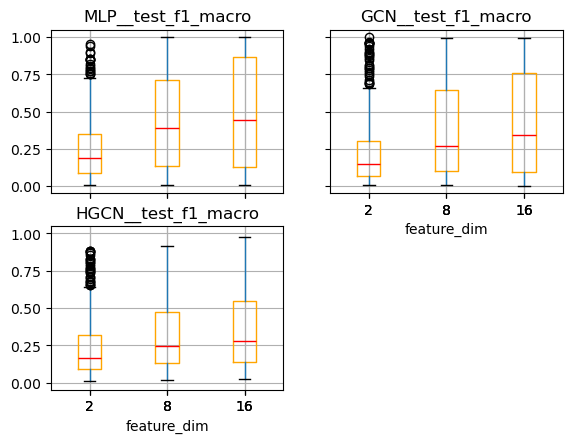


Dimension 2:
--------
MLP mean: 0.25, std: 0.21
GCN mean: 0.23, std: 0.21
HGCN mean: 0.23, std: 0.19

Dimension 8:
--------
MLP mean: 0.44, std: 0.30
GCN mean: 0.37, std: 0.30
HGCN mean: 0.32, std: 0.24

Dimension 16:
--------
MLP mean: 0.49, std: 0.36
GCN mean: 0.43, std: 0.34
HGCN mean: 0.36, std: 0.25


In [108]:
two_df['feature_dim']     = 2
eight_df['feature_dim']   = 8
sixteen_df['feature_dim'] = 16
combined_df = pd.concat([two_df, eight_df, sixteen_df], ignore_index=True)

# Step B: call any of the functions above. For example:
dims = [2,8,16]
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_f1_macro'

# 1) Boxplot by feature_dim
boxplot_metric_by_feature_dim(combined_df, models, metric)
for dim in dims:
    print(f"\nDimension {dim}:\n--------")
    for model in models:
        mod_dim_per_df = combined_df[combined_df['feature_dim']==dim][f'{model}__{metric}']
        print(f'{model} mean: {mod_dim_per_df.mean():.2f}, std: {mod_dim_per_df.std():.2f}') 


All models struggle when feature dimension is 2. Performance is widely varied, with all models capable of performing well on outlier graphs, with the general spread of performance under .4 (see bar plots). Across dimensions, the standard deviation of all models increases. The relative order of performance is consistent across dimensions: MLP > GCN > HGCN. 

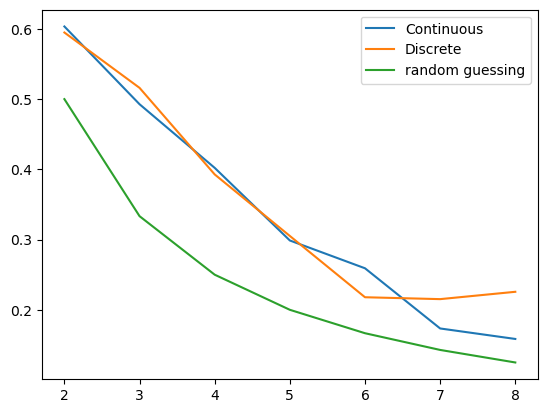

In [157]:
model = 'HGCN'

perf_cts = cts_hyp_df.groupby('num_clusters')[model + '__'+metric].mean()
perf_dis = sixteen_df.groupby('num_clusters')[model + '__' + metric].mean()
rand_guess = np.array([1/el for el in np.arange(2,9)])

plt.plot(perf_cts, label = 'Continuous')
plt.plot(perf_dis, label = 'Discrete')
plt.plot(np.arange(2,9), rand_guess, label = 'random guessing')
plt.legend()
plt.show()

We compute several metrics, pertaining to both the graph and the node-features. These are:

* **Edge homogeneity** → Fraction of edges whose endpoints share the same label (measures how assortative the graph is with respect to the true classes).

* **Avg in feature angular distance** → Average angular‐similarity among feature vectors of nodes within the same class (measures intra‐class feature cohesion).

* **Avg out feature angular distance** → Average angular‐similarity among feature vectors of nodes across different classes (measures inter‐class feature overlap).

* **Feature angular SNR** → Ratio of in‐class similarity to out‐of‐class similarity (high ⇒ features separate classes well).

* **Pareto exponent** → Fitted power‐law exponent of the positive degree sequence (low exponent ⇒ heavier‐tailed, hub-dominated degree distribution).

* **Avg degree est** → Mean node degree (measures overall graph sparsity/density).

* **Community size Simpsons** → Simpson index \$\sum\_i \pi\_i^2\$ over class sizes (high ⇒ very imbalanced class sizes) where \$\pi\_i\$ is probability that node is in class \$i\$.

* **P to Q ratio est** → (Observed within‐class edge density) / (observed between‐class edge density) using unweighted class proportions (measures edge‐based assortativity).

* **P to Q ratio est DC** → Same \$p/q\$ ratio but degree‐corrected (uses sum of degrees per class in the denominator).

* **Num clusters** → Number of distinct labels (i.e. ground-truth communities).

It is of interest to us how these correlate with model performance. Restricting to a node-feature dimension of 16, we observe:


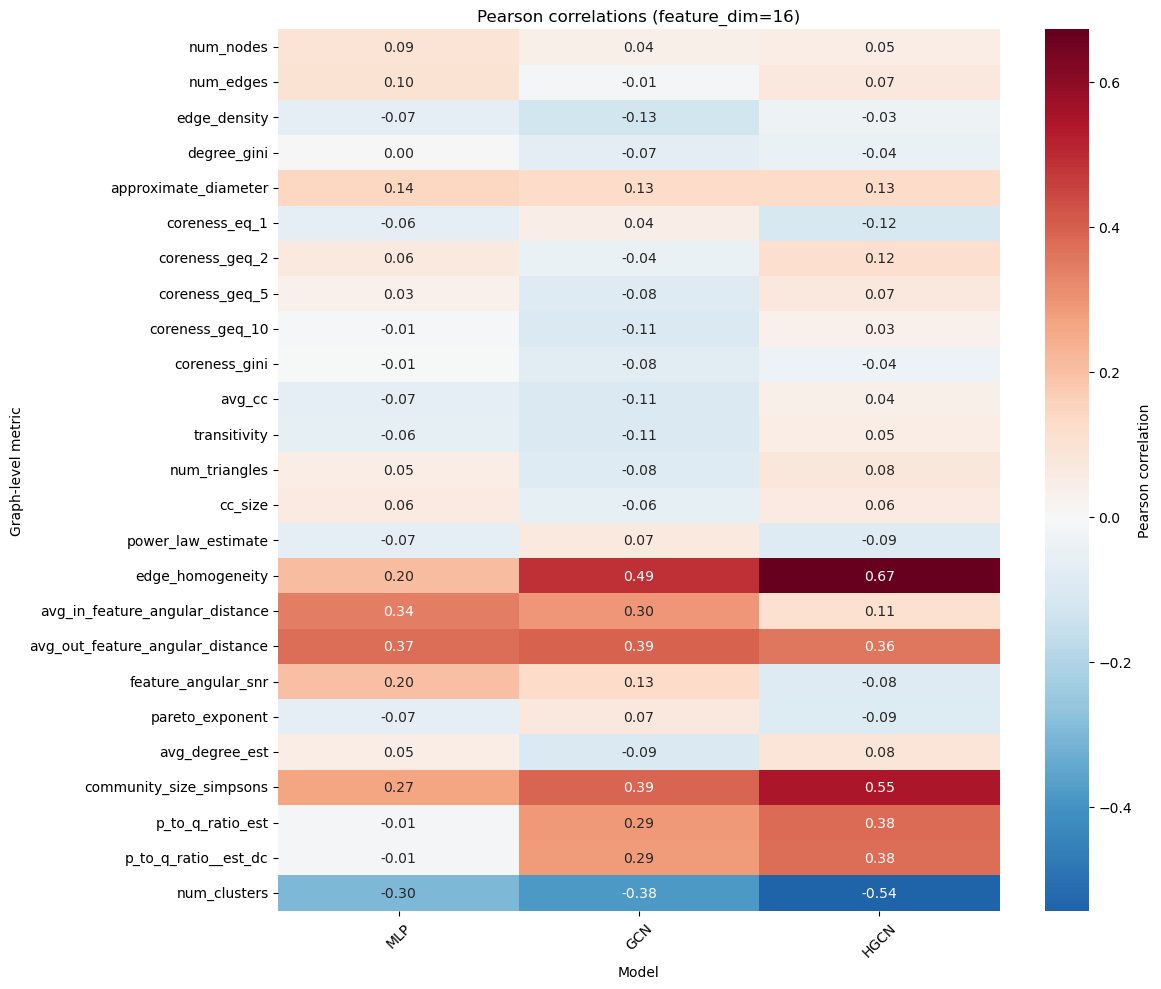

In [208]:
graph_metrics = [
    "num_nodes", "num_edges", "edge_density",
    "degree_gini", "approximate_diameter", "coreness_eq_1",
    "coreness_geq_2", "coreness_geq_5", "coreness_geq_10", "coreness_gini",
    "avg_cc", "transitivity", "num_triangles", "cc_size",
    "power_law_estimate", "edge_homogeneity",
    "avg_in_feature_angular_distance", "avg_out_feature_angular_distance",
    "feature_angular_snr", "pareto_exponent", "avg_degree_est",
    "community_size_simpsons", "p_to_q_ratio_est", "p_to_q_ratio__est_dc", 'num_clusters'
]

models = ["MLP", "GCN", "HGCN"]

corr_df = compute_and_plot_graph_metric_correlations(
    df=combined_df,
    feature_dim=16,
    graph_metrics=graph_metrics,
    models=models,
    perf_suffix="test_f1_macro",
    corr_method="pearson",      # or "spearman"
    figsize=(12, 10)
)


What we observe: both GCN models benefit from edge homogeniety. This makes sense, since they rely on the assumption that similarly classed nodes are connected in the graph. It is particularly strong for the HGCN, with an r-value of .67. All models have a moderate correlation with avg_out_feature_angular_distance, which measures the average angular similarity between the node-features of differingly classed nodes. Thus, when this distance is larger, it is easier to discriminate from the node-features the class, and all models do better. There is a monotonic response to community_size_simpsons, where MLP has a small to moderate correlation, the GCN moderate and the HGCN moderate to high. This metric measures the class size imbalances in a graph, with a large value signifying very unbalanced classes. This implies then that the HGCN performs better when there is a large class size discrepancy.  

One of the primary things we are interested in saying something about is given a graph, what model type should be used. To answer this, we fit a random forest model where the independent variables are the graph metrics (to make the picture clearer, if no model has r>.15 with a metric we discard it) above, and the dependent variables are MLP and GCN performance, wrt f1-macro.

In [211]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# 1) Load your combined DataFrame and restrict to feature_dim = 16
df = combined_df.copy()
df16 = df[df["feature_dim"] == 16].reset_index(drop=True)

# 2) Identify “eligible” graph‐metrics whose Pearson |r| > 0.15 with MLP or GCN test‐F1

# (a) list of all graph‐metric column names
graph_metrics = [
    "num_nodes", "num_edges", "edge_density", "degree_gini", "approximate_diameter",
    "coreness_eq_1", "coreness_geq_2", "coreness_geq_5", "coreness_geq_10",
    "coreness_gini", "avg_cc", "transitivity", "num_triangles", "cc_size",
    "power_law_estimate", "edge_homogeneity", "avg_in_feature_angular_distance",
    "avg_out_feature_angular_distance", "feature_angular_snr", "pareto_exponent",
    "avg_degree_est", "community_size_simpsons", "p_to_q_ratio_est",
    "p_to_q_ratio__est_dc"
]

# (b) performance columns for MLP and GCN
perf_cols = {
    "MLP": "MLP__test_f1_macro",
    "GCN": "GCN__test_f1_macro"
}

eligible_metrics = set()
for metric in graph_metrics:
    if metric not in df16.columns:
        continue

    # drop any rows where either metric or perf is not finite
    sub = df16[[metric, perf_cols["MLP"], perf_cols["GCN"]]].dropna()
    x = sub[metric].values
    
    # MLP
    y_m = sub[perf_cols["MLP"]].values
    finite_mask_m = np.isfinite(x) & np.isfinite(y_m)
    if finite_mask_m.sum() >= 3:
        r_m, _ = pearsonr(x[finite_mask_m], y_m[finite_mask_m])
    else:
        r_m = 0.0

    # GCN
    y_g = sub[perf_cols["GCN"]].values
    finite_mask_g = np.isfinite(x) & np.isfinite(y_g)
    if finite_mask_g.sum() >= 3:
        r_g, _ = pearsonr(x[finite_mask_g], y_g[finite_mask_g])
    else:
        r_g = 0.0

    if abs(r_m) > 0.15 or abs(r_g) > 0.15:
        eligible_metrics.add(metric)

eligible_metrics = sorted(eligible_metrics)
print(f"Eligible graph‐metrics (|r| > 0.15):\n{eligible_metrics}\n")

# 3) Build a “label” column: 1 if GCN wins, 0 if MLP wins (drop ties)
df16["best_model"] = np.where(
    df16[perf_cols["GCN"]] > df16[perf_cols["MLP"]], "GCN", "MLP"
)
# drop rows where they tie exactly or where either is NaN
df16 = df16.dropna(subset=[perf_cols["MLP"], perf_cols["GCN"]])
df16 = df16[df16[perf_cols["GCN"]] != df16[perf_cols["MLP"]]].reset_index(drop=True)

# 4) Prepare the feature matrix X and target y
X = df16[eligible_metrics].copy()
y = df16["best_model"].map({"MLP": 0, "GCN": 1}).values

# (Optionally) Impute any remaining infinities or large outliers—here we simply fill infinities with column median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape)

# 6) Fit a Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 7) Evaluate on the held‐out test set
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy (MLP vs GCN): {acc:.3f}\n")
print(classification_report(y_test, y_pred, target_names=["MLP","GCN"]))

# 8) Optional: 5‐fold cross‐validation accuracy
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy", n_jobs=-1)
print(f"5‐fold CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 9) Examine feature importances
importances = pd.Series(rf.feature_importances_, index=eligible_metrics)
importances = importances.sort_values(ascending=False)
print("\nFeature importances (most→least):")
print(importances.head(10))


Eligible graph‐metrics (|r| > 0.15):
['avg_in_feature_angular_distance', 'avg_out_feature_angular_distance', 'community_size_simpsons', 'edge_homogeneity', 'feature_angular_snr', 'p_to_q_ratio__est_dc', 'p_to_q_ratio_est']

(392, 7)
Test accuracy (MLP vs GCN): 0.616

              precision    recall  f1-score   support

         MLP       0.63      0.79      0.70        57
         GCN       0.57      0.38      0.46        42

    accuracy                           0.62        99
   macro avg       0.60      0.59      0.58        99
weighted avg       0.61      0.62      0.60        99

5‐fold CV accuracy: 0.578 ± 0.037

Feature importances (most→least):
p_to_q_ratio__est_dc                0.171111
edge_homogeneity                    0.155876
p_to_q_ratio_est                    0.152864
avg_out_feature_angular_distance    0.135348
feature_angular_snr                 0.130778
community_size_simpsons             0.128397
avg_in_feature_angular_distance     0.125627
dtype: float64


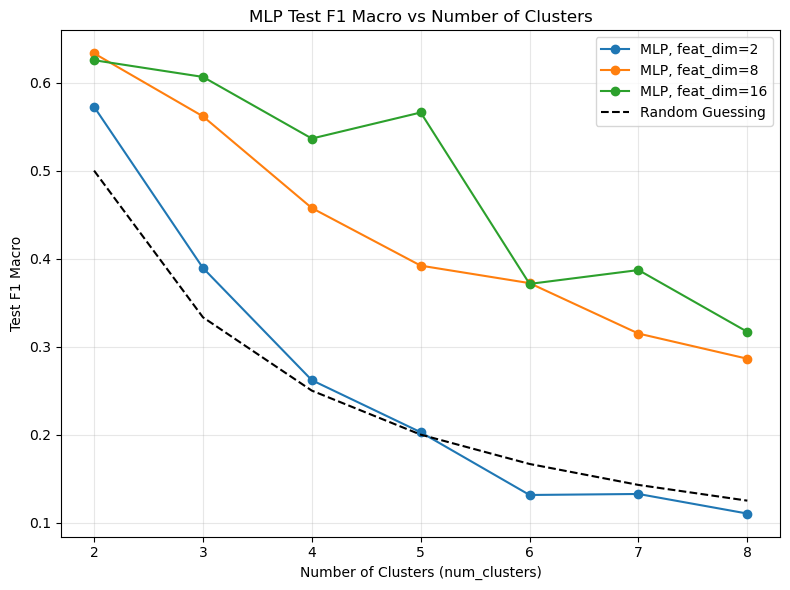

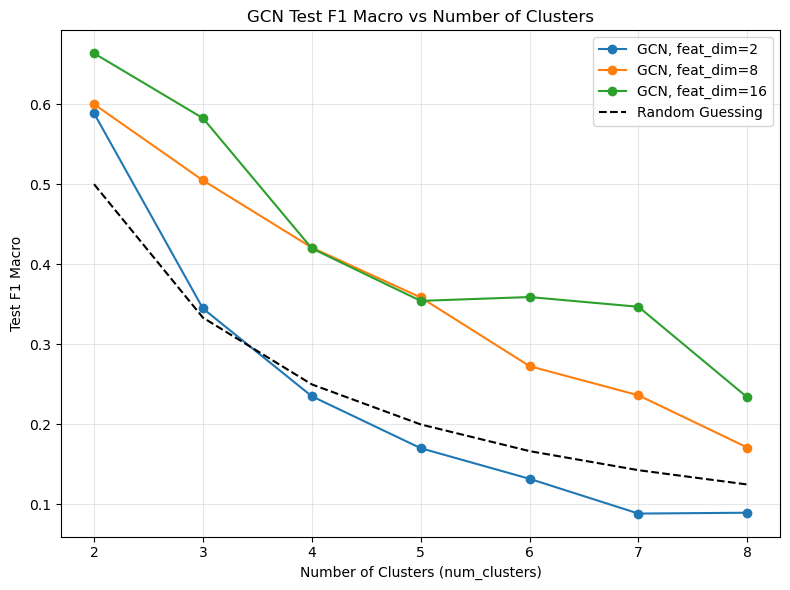

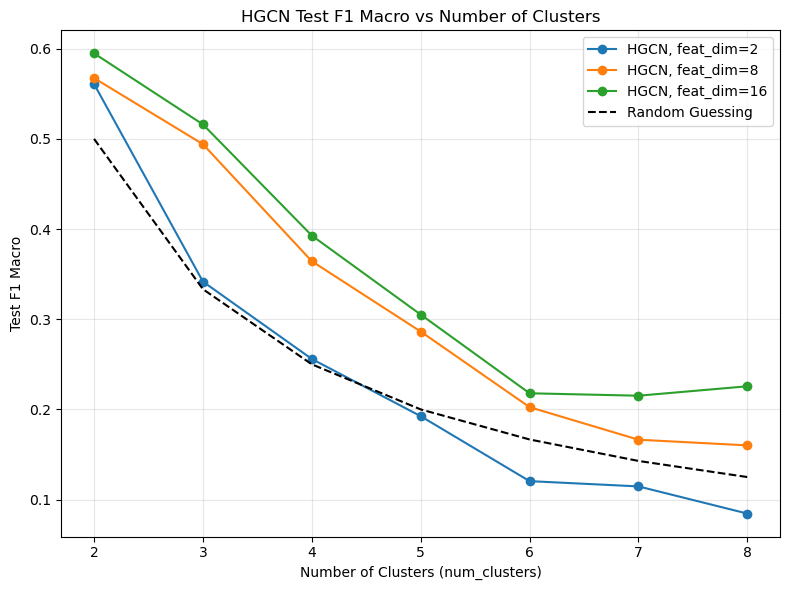

In [70]:
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_f1_macro'
for model in models:
    plot_performance_vs_clusters(combined_df, model, metric)

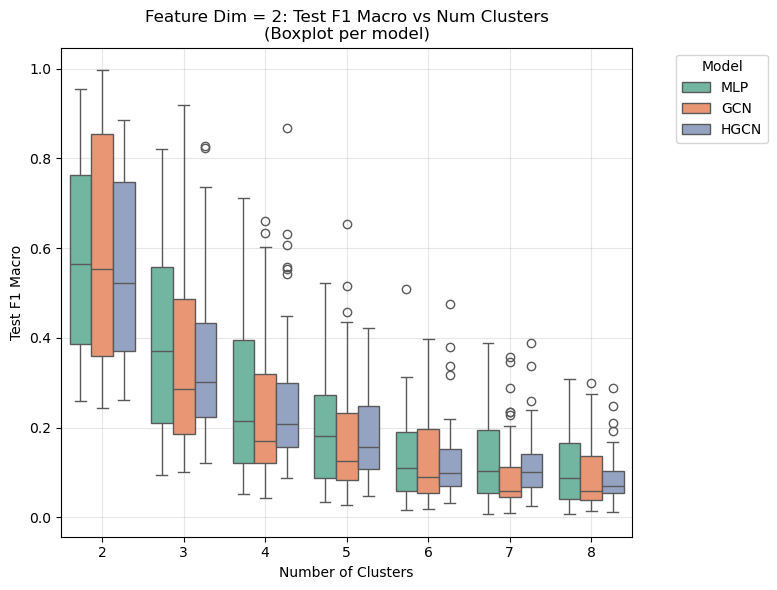

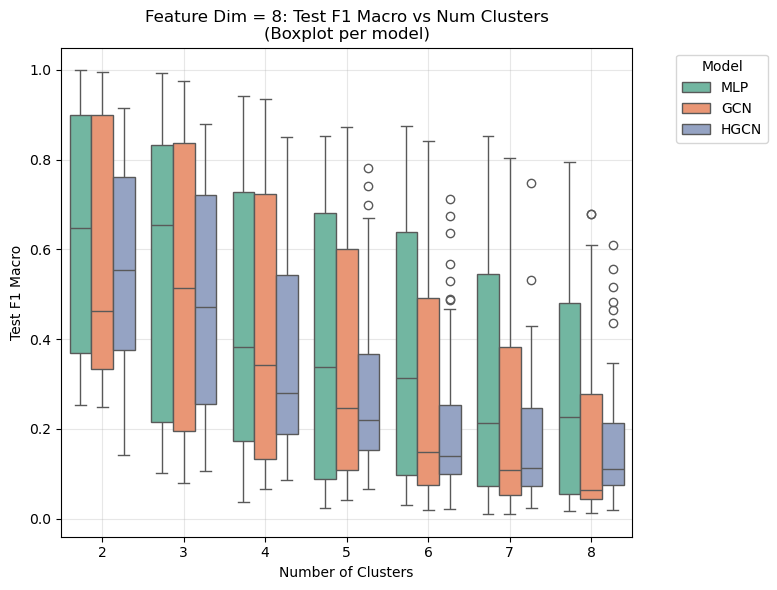

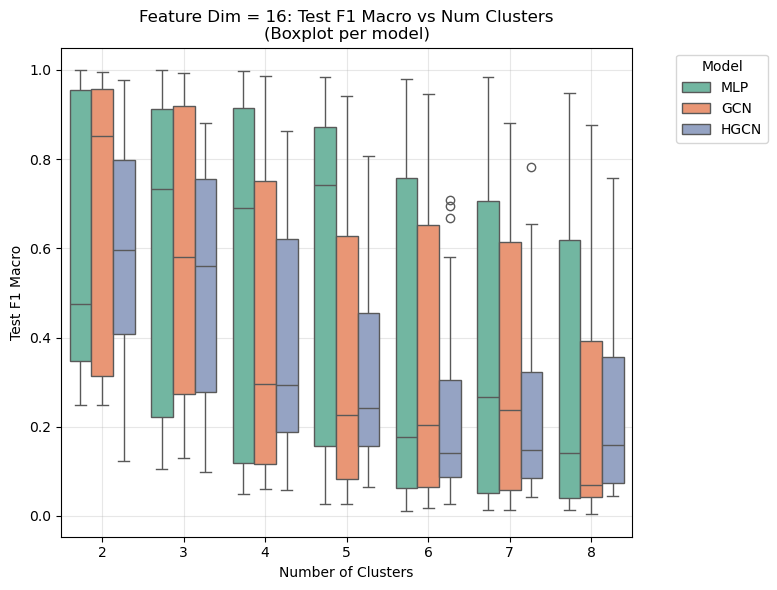

In [90]:
for dim in [2, 8, 16]:
    boxplot_models_vs_clusters_for_dim(combined_df, feature_dim=dim, models = models, metric = 'test_f1_macro')

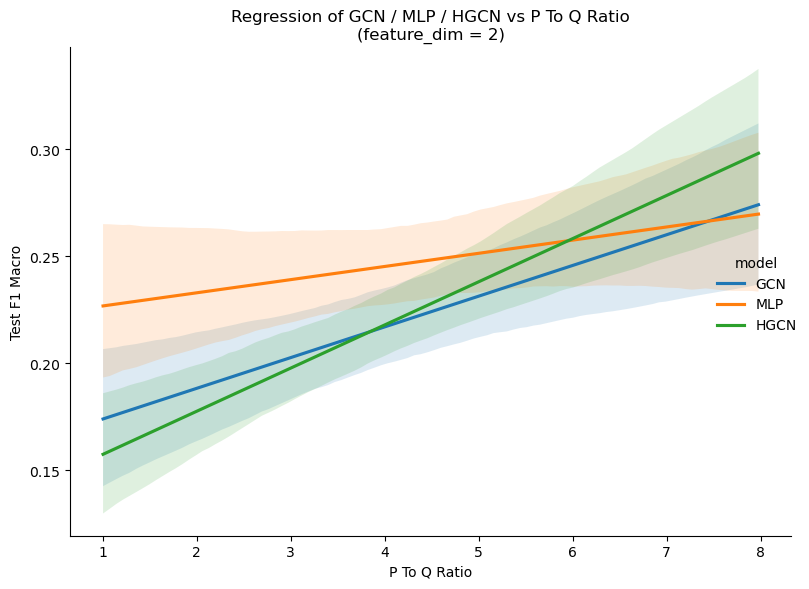

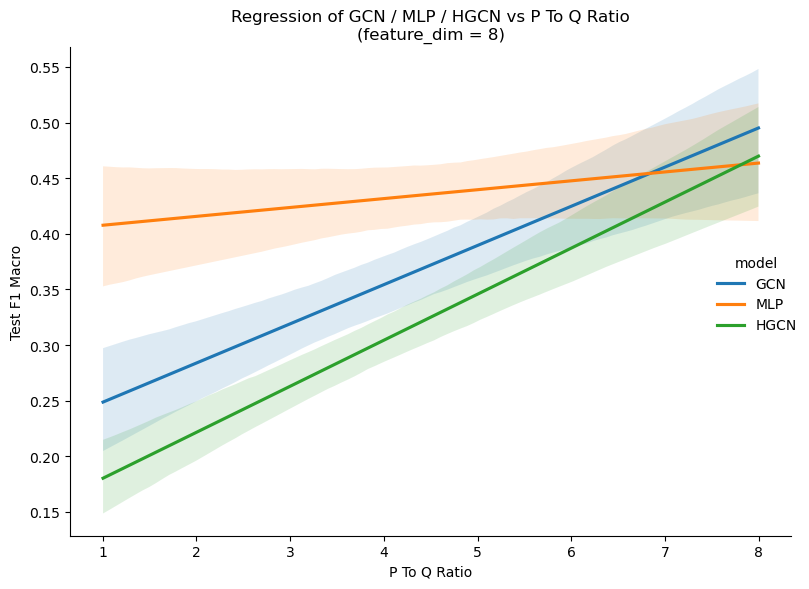

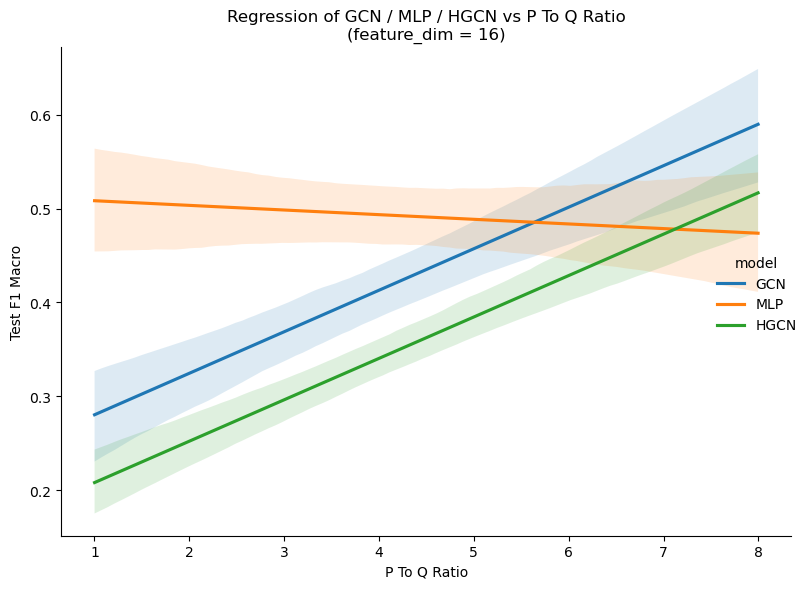

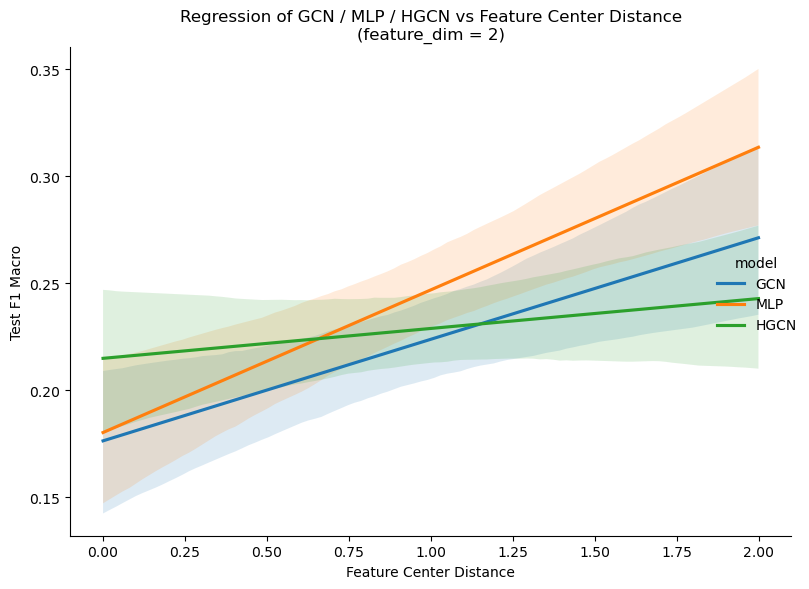

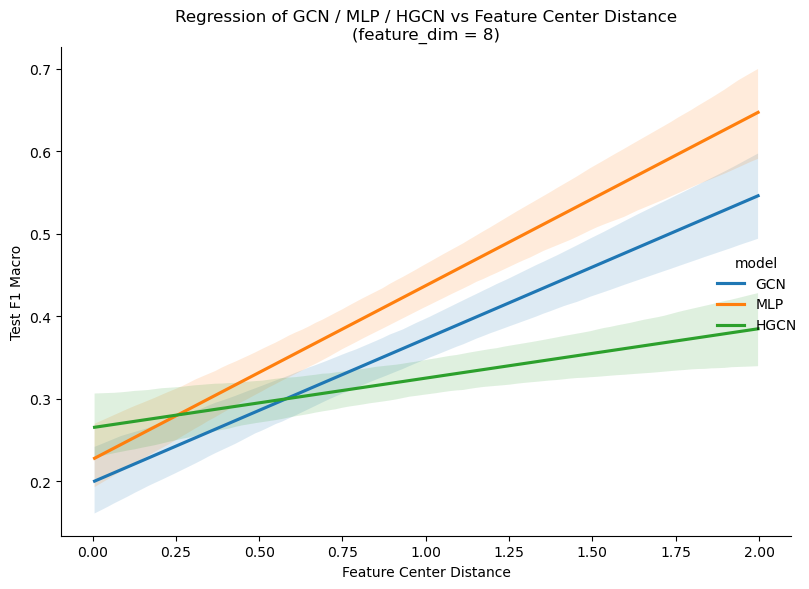

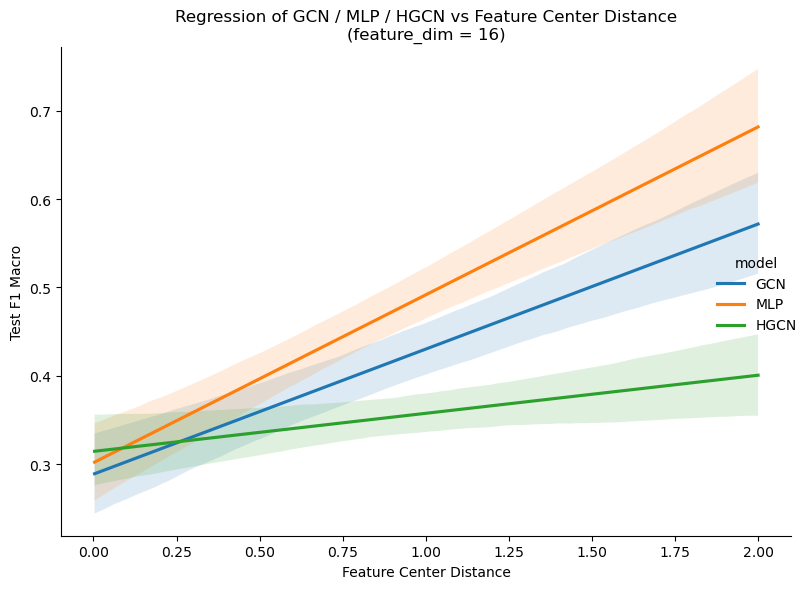

In [92]:
from itertools import product

for gen_param, dim in product(['p_to_q_ratio', 'feature_center_distance'], [2, 8, 16]):
    plot_all_models_regression_for_dim(combined_df=combined_df, feature_dim = dim, metric= metric, x_col = gen_param)

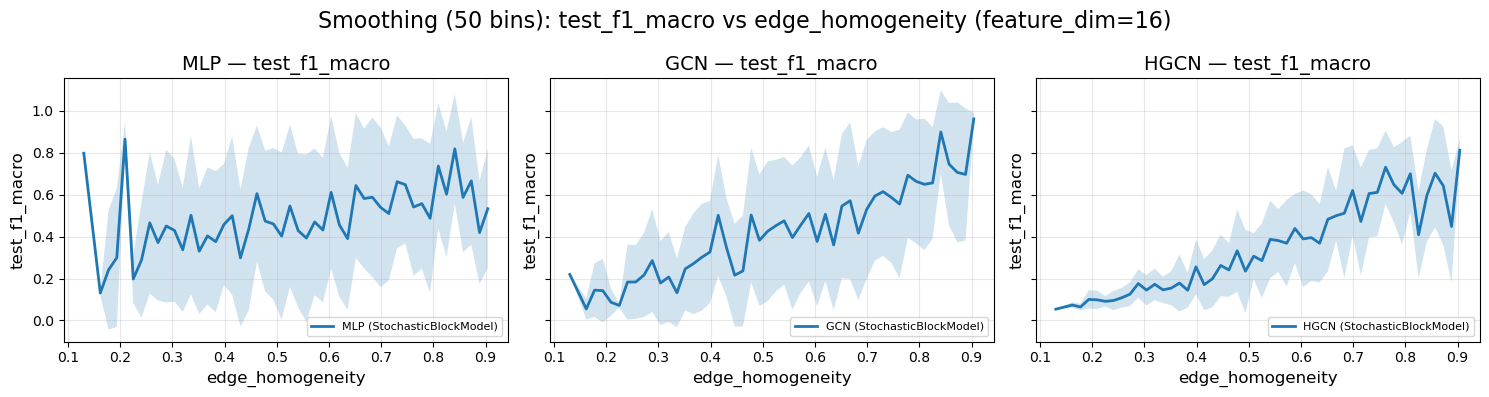

In [224]:
models = ["MLP", "GCN", "HGCN"]
metric = "edge_homogeneity"
perf_meas = "test_f1_macro"
feature_dim = 16

smooth_binning_plots(
    df=combined_df,
    models=models,
    perf_meas=perf_meas,
    metric=metric,
    feature_dim=feature_dim,
    num_bins=50
)

In [226]:
import numpy as np
from sklearn.preprocessing import normalize

def generate_hierarchical_features(
    labels: np.ndarray,
    feature_dim: int,
    alpha: float,
    base_distance: float,
    noise_variance: float = 1.0,
    num_supergroups: int = None,
    random_seed: int = 0
) -> np.ndarray:
    """
    Generate D-dimensional node features for nodes 1..N given their class labels,
    using a one‐parameter interpolation alpha ∈ [0,1] between:
       • alpha=0: flat Gaussian mixture (K class means i.i.d. from N(0, d^2 I))
       • alpha=1: pure 2‐level hierarchy (G super‐means ~ N(0,d^2 I), each class mean = parent super‐mean).
    
    Args:
      labels          : 1D array of length N, each entry in {0..K−1} is the class index of node i.
      feature_dim     : Dimensionality D of each node feature vector.
      alpha           : Float in [0,1], interpolation between flat (0) and hierarchical (1).
      base_distance   : Positive float d.  This is the “cluster separation scale.” 
                        If alpha=0, class‐means ~ N(0, d^2 I).  If alpha=1, super‐means ~ N(0, d^2 I).
      noise_variance  : Variance σ_noise^2 > 0 used for final “node‐noise” around the chosen class mean. 
                        (Default: 1.0)
      num_supergroups : If None, we choose G = ceil(sqrt(K)), and assign classes
                        to supergroups via a round‐robin.  Otherwise, G = num_supergroups must 
                        be ≤ K.
      random_seed     : For reproducibility of random draws.
    
    Returns:
      X: numpy array of shape (N, feature_dim).  Each row is x_i ∈ ℝ^D.
    
    --------------------------------------------------
    Mathematical steps internally:
      1) Let K = # distinct classes = number of unique labels.
      2) Choose G = num_supergroups (or G = ceil(sqrt(K))) as the # of super‐clusters.
      3) Build a mapping `class_to_super[k]` ∈ {0..G−1}, assigning each of the K classes 
         to one of G super‐clusters (balanced as evenly as possible).
      4) Top‐level (“super‐means”) variance:
           τ_top = alpha * base_distance.
         Mid‐level (“class‐means”) variance:
           τ_class = (1 − alpha) * base_distance.
         Node‐noise variance = noise_variance.
      5) Draw G super‐means μ_top[j] ∼ N(0, τ_top^2 I_D), j=0..G−1.
      6) For each class k=0..K−1, let j = class_to_super[k].  Then draw 
           μ_class[k] ∼ N( μ_top[j], τ_class^2 I_D ).
      7) For each node i∈{1..N}, let k = labels[i].  Then draw 
           x_i ∼ N( μ_class[k], noise_variance * I_D ).
      8) (Optional) ℓ2‐normalize each x_i to unit length (or skip if you prefer).
    --------------------------------------------------
    """

    np.random.seed(random_seed)
    labels = np.asarray(labels, dtype=int)
    N = labels.shape[0]
    unique_classes = np.unique(labels)
    K = unique_classes.shape[0]
    # Build a map from actual label values to 0..(K-1)
    # (in case labels were not exactly 0..K-1)
    class_list = sorted(unique_classes.tolist())
    class_to_index = { c: idx for idx, c in enumerate(class_list) }
    # Remap labels into a 0..K-1 array
    remapped = np.array([class_to_index[c] for c in labels], dtype=int)

    # 1) Determine number of super‐clusters G
    if num_supergroups is None:
        G = int(np.ceil(np.sqrt(K)))
    else:
        G = int(num_supergroups)
        if G > K:
            raise ValueError("num_supergroups must be ≤ number of distinct classes")

    # 2) Assign each class‐index k∈{0..K-1} to a super‐cluster in {0..G-1}.
    #    We do a simple round‐robin / “balanced” assignment:
    class_to_super = np.zeros(K, dtype=int)
    for k in range(K):
        class_to_super[k] = k % G
    # Now class_to_super[k] is an integer in [0..G-1].

    # 3) Compute top‐ and mid‐level standard deviations
    tau_top   = alpha * base_distance
    tau_class = (1.0 - alpha) * base_distance

    # 4) Draw the G super‐means in R^D: μ_top[j] ~ N(0, (τ_top)^2 I_D)
    mu_top = np.random.randn(G, feature_dim) * tau_top

    # 5) Draw the K class‐means: 
    #    For each k=0..(K-1), let j = class_to_super[k], then
    #      μ_class[k] ~ N( μ_top[j], (τ_class)^2 I_D ).
    mu_class = np.zeros((K, feature_dim))
    for k in range(K):
        j = class_to_super[k]
        mu_class[k] = mu_top[j] + np.random.randn(feature_dim) * tau_class

    # 6) Finally, for each node i=0..(N-1), let k = remapped[i], 
    #    then draw x_i ~ N( mu_class[k], noise_variance I_D ).
    X = np.zeros((N, feature_dim))
    for i in range(N):
        k = remapped[i]
        X[i] = mu_class[k] + np.random.randn(feature_dim) * np.sqrt(noise_variance)

    # 7) (Optional) L2‐normalize each row to unit length.  If you prefer not to normalize,
    #    simply comment out the next two lines.
    X = normalize(X, norm='l2', axis=1)

    return X



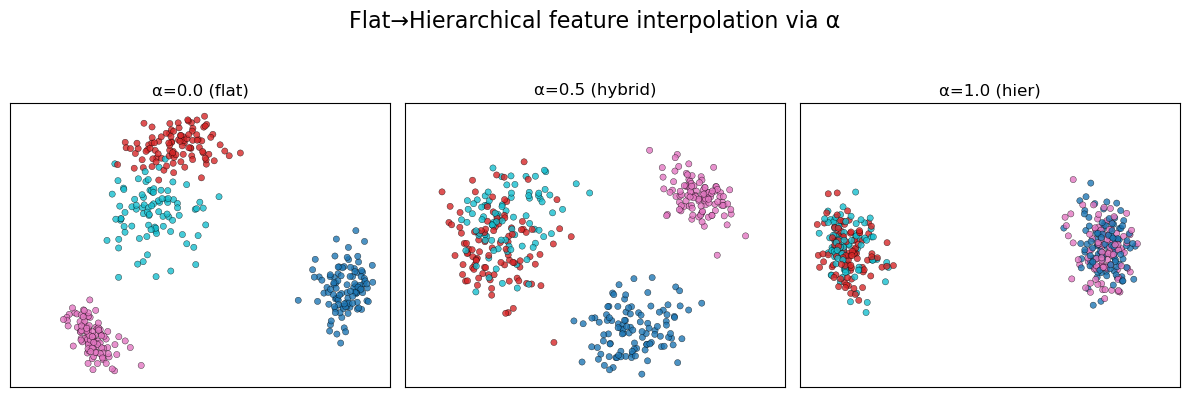

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Choose number of nodes & classes ===
N = 400
K = 4
labels = np.random.choice(K, size=N)  # random assignment to 4 classes
D = 16                                # we will generate 16‐dim features

base_d = 2.0    # choose a separation scale
sigma_noise = 1.0

# Values of alpha to test
alphas = [0.0, 0.5, 1.0]
titles = ["α=0.0 (flat)", "α=0.5 (hybrid)", "α=1.0 (hier)"]

# Build figure
fig, axes = plt.subplots(1, len(alphas), figsize=(12, 4), sharex=True, sharey=True)

for ax, α, title in zip(axes, alphas, titles):
    X = generate_hierarchical_features(
        labels=labels,
        feature_dim=D,
        alpha=α,
        base_distance=base_d,
        noise_variance=sigma_noise,
        # force exactly 2 super‐groups so you see the hierarchy clearly
        num_supergroups=2,
        random_seed=42
    )
    # Reduce to 2D via PCA for plotting
    X2 = PCA(n_components=2).fit_transform(X)

    scatter = ax.scatter(
        X2[:, 0], X2[:, 1],
        c=labels, cmap="tab10", s=20, alpha=0.8,
        edgecolor="k", linewidth=0.3
    )
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Flat→Hierarchical feature interpolation via α", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()
